In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
import cmath
import csv

nsamples = 4_096
fs = 44_100

# 1. 构建时域信号

In [3]:
def generate_signal(samples = 2048, fs = 44_100):
    f0, f1, f2, f3, f4 = 1_000, 4_000, 6_000, 8_000, 17_357
    ts = 1 / fs
    time = np.linspace(0, samples*ts, samples)

    tone_0 = 1 * np.sin(2*np.pi*f0*time)
    tone_1 = 0.8 * np.sin(2*np.pi*f1*time)
    tone_2 = 2 * np.sin(2*np.pi*f2*time)
    tone_3 = 0.1 * np.sin(2*np.pi*f3*time)
    tone_4 = 0.3* np.sin(2*np.pi*f4*time)
    signal = tone_0 + tone_1 + tone_2*1j + tone_3*1j + tone_4*1j
    return signal

signal = generate_signal(nsamples, fs)
print(len(signal))

4096


# 2. 使用Scipy计算FFT并可视化

D:\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


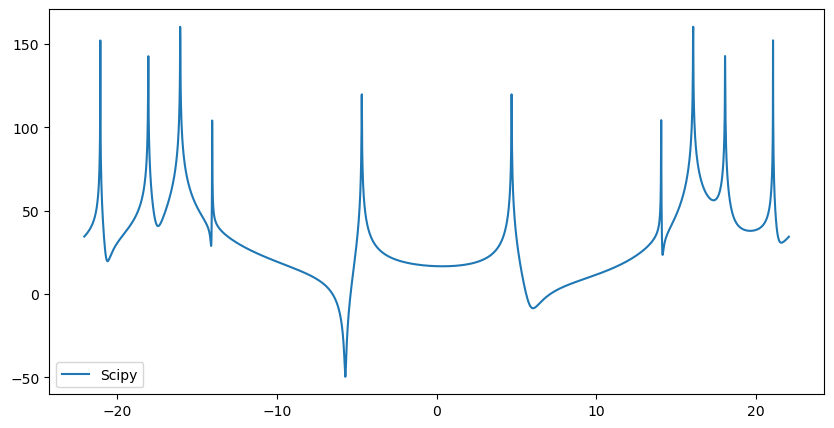

In [4]:
def compute_fft(data, fs = 44_100):
    samples = len(data)
    ts = 1 / fs
    spectrum = np.fft.fft(data)
    freqs = np.fft.fftshift(np.fft.fftfreq(samples, d=ts))
    return spectrum, freqs

# 计算FFT
spectrum, freqs = compute_fft(signal, fs)

# 绘制频谱图
plt.figure(figsize=(10, 5))
plt.plot(freqs / 1e3, 20*np.log(spectrum), label="Scipy")
plt.legend()

# 3. 保存时域信号

In [5]:
def vector2file_cint16(data: np.array, file: str, plio = 128, bits = 16, scale: bool=True):
    """
    data: samples
    file: output filename
    plio: bit width of the PLIO port
    bits: bit precision per sample
    """
    """Scale signal to use full precision"""
    maxr = np.max(np.abs(data.real))
    maxi = np.max(np.abs(data.imag))
    maxv = maxr if maxr > maxi else maxi
    if scale:
        vscale = 2**int(np.floor(np.log2((1 << (bits-1)) / maxv)))
        vscale = 1<<6
    else:
        vscale = 1
    data = data * (vscale if scale else 1)
    """Write value to file"""
    with open(file, 'w', newline='') as f:
        for i, v in enumerate(data):
            r = np.int16(v.real)
            c = np.int16(v.imag)
            f.write("{} {} ".format(r, c))
            if (((i+1) % 4) == 0 and plio == 128) or (((i+1) % 2) == 1 and plio == 64):
                f.write('\n')
    return vscale

# 由于AIE使用了4个plio，所以AIE仿真的输入文件分4个导出
data_in_pl = np.empty(0,) # 合并4个输入文件，作为PL的输入
for i in range(4):
    data_in_pl = np.concatenate((data_in_pl, signal[i::4]))
    vscale = vector2file_cint16(signal[i::4], '../aie/data/DataInFFT'+str(i)+'.txt', scale=True)

# 合并4个文件，作为PL的输入
vscale = vector2file_cint16(data_in_pl, '../execution/DataInFFT0.txt', scale=True)
print(vscale)

64


# 4. 执行AIE

# 5. 读取AIE/PL输出

In [9]:
def read_file(file: str, samples: int):
    value = np.zeros(samples, dtype=np.complex128)
    count = 0
    with open(file,'r') as f:
        reader = csv.reader(f, delimiter=" ")
        for line in reader:
            if 'T' in line[0]:
                continue
            for i in range(0, len(line), 2):
                if line[i] != '':
                    value[count] = np.int16(line[i]) + 1j* np.int16(line[i+1])
                    count = count + 1
    return value

read_from_aie = False

if ( read_from_aie ): # use the output from AIE
    signal_read0 = read_file('../aie/data/DataOutFFT0.txt', nsamples//4)
    signal_read1 = read_file('../aie/data/DataOutFFT1.txt', nsamples//4)
    signal_read2 = read_file('../aie/data/DataOutFFT2.txt', nsamples//4)
    signal_read3 = read_file('../aie/data/DataOutFFT3.txt', nsamples//4)
    signal_read = np.concatenate([signal_read0, signal_read1, signal_read2, signal_read3])
else: # use the output from PL
    signal_read = read_file('../execution/DataOutFFT0.txt', nsamples) # read from pl

print(signal_read)

[ 274.+230.j -325.-117.j  -37. +83.j ...  522.+287.j  477.+511.j
  406.+250.j]


# 6. 可视化AIE/PL输出

D:\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


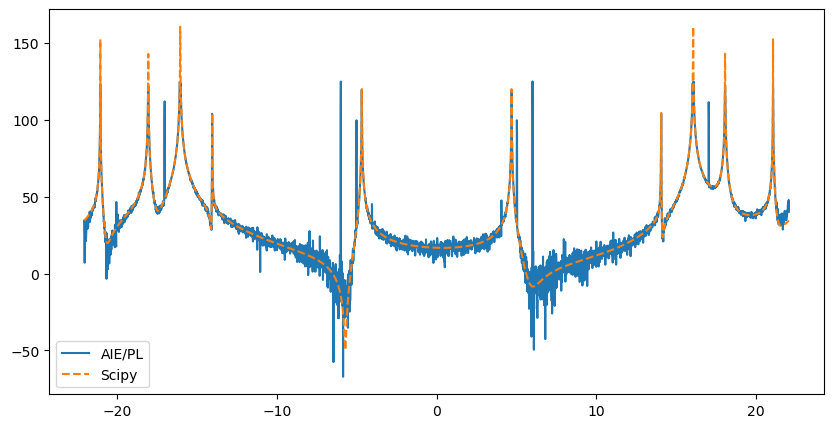

In [7]:
plt.figure(figsize=(10,5))
plt.plot(freqs / 1e3, 20*np.log(signal_read/vscale), label="AIE/PL")
plt.plot(freqs / 1e3, 20*np.log(spectrum), label="Scipy",linestyle='--')
plt.legend()

# 7. 验证AIE/PL输出

In [10]:
error = spectrum - signal_read
print(np.max(np.abs(error.real)))
print(np.max(np.abs(error.imag)))

def findmax(fftnp, fftaie):
    print(f'Numpy: Max Real {np.max(np.abs(fftnp.real))}, Max Imag {np.max(np.abs(fftnp.imag))}')
    print(f'Numpy: Max Real {np.max(np.abs(fftaie.real))}, Max Imag {np.max(np.abs(fftaie.imag))}')

findmax(spectrum, signal_read)

29802.345408104928
30928.471803758523
Numpy: Max Real 1184.325379618681, Max Imag 2925.1613477124156
Numpy: Max Real 29803.0, Max Imag 31433.0
